Functions to generate image of an encounter

In [4]:
from pathlib import Path
from PIL import Image, ImageDraw
import json

def split_battle_spot(file_name: str):
  # Split the battle spots (user and opponents battle spot)
  path_name = Path(file_name)
  battle_spot = Image.open(file_name)
  crop_offset = 0
  field_name = path_name.stem
  if field_name == "cynthia":
    crop_offset = 1
  elif field_name in ["aaron", "bertha", "flint", "lucian"]:
    crop_offset = 2

  battle_spot_left = battle_spot.crop((0, battle_spot.height / 2 + (crop_offset), 256, battle_spot.height))
  battle_spot_right = battle_spot.crop((0, 0, 256, battle_spot.height / 2 + (crop_offset)))
  
  return battle_spot_left, battle_spot_right

def generate_shadow(img: Image, center: tuple[int, int], widths: list[int], doubled_center: bool):
    """Draws an ellipsis shadow on image."""
    img_draw = ImageDraw.Draw(img)
    
    for i, w in enumerate(widths):
        x1 = center[0] - (w / 2)
        x2 = center[0] + (w / 2)
        y1 = center[1] - i if doubled_center == False else center[1] - i - 1
        y2 = center[1] + i
        img_draw.line(xy=[(x1, y1), (x2, y1)], fill=(98, 85, 101, 255), width=1)
        img_draw.line(xy=[(x1, y2), (x2, y2)], fill=(98, 85, 101, 255), width=1)
    
    return img

def generate_encounter(sprite_file: str, field_type: str, battle_spot_type: str, pkmn_index: int, x: int, y: int, center: tuple[int, int], widths: list[int], doubled_center: bool):
  """Generates an recreation of a Pokemon Encounter"""
  dataset_dir = "../assets/PokemonGen4/"
  rand_field = Image.open(f"../assets/fields/{field_type}.png")
  #rand_spot = Image.open("battle_spots/grass_day.png")
  rand_spot_left, rand_spot_right = split_battle_spot(f"../assets/battle_spots/{battle_spot_type}.png")
  sprite = Image.open(sprite_file)
  sprite = sprite.convert("RGBA")

  rand_field.paste(im=rand_spot_left, box=(-64, 120), mask=rand_spot_left)
  rand_field.paste(im=rand_spot_right, box=(64, 64), mask=rand_spot_right)
  rand_field = generate_shadow(img=rand_field, center=center, widths=widths, doubled_center=doubled_center)
  #img_draw = ImageDraw.Draw(rand_field)
  #img_draw.line(xy=[(5, 5), (5, 100)], fill=(98, 85, 101, 255), width = 5)
  rand_field.paste(im=sprite, box=(x, y), mask=sprite)
  return rand_field

- Loading encounter information (coordinates and shadows) to dictionaries
- Generating field / battle spot pairs

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("../dataset", exist_ok=True)

with open("encounter_info.json") as f:
    coordinates_dict = json.load(f)

with open("encounter_shadows.json") as f:
    shadow_dict = json.load(f)

with open("field_map.json") as f:
    field_map = json.load(f)

# Generate field & battle spot pairs
f_bs_pairs = []
weights = [] # Custom weights set to prioritize field and battle spots likely to encounter in the wild

for key in field_map.keys():
    for bs in field_map[key]["battle_spots"]:
        f_bs_pairs.append((key, bs))
        weights.append(field_map[key]["weight"])

weights = np.array(weights, dtype=float)
weights /= weights.sum()

print(len(f_bs_pairs))
rng = np.random.default_rng()
games = ["dp", "pt", "hgss"]

50


In [6]:
from PIL import Image
import numpy as np

def pad_and_rescale_image_to_square(img, target_size, bbox, fill_color=(114, 114, 114)):
    """
    Pads and rescales an image to a square canvas of target_size x target_size,
    centered with equal padding on the shorter dimension (top/bottom or left/right).
    Also adjusts the bounding box coordinates to match the new image.

    Args:
        img (PIL.Image): The input image (already resized but not square).
        target_size (int): The dimension of the square canvas (e.g., 640).
        bbox (tuple): Original bounding box as (x1, y1, x2, y2).
        fill_color (tuple): RGB color for the padding (YOLO default is 114, 114, 114).

    Returns:
        tuple: (new_img, new_bbox)
            - new_img (PIL.Image): The newly padded square image.
            - new_bbox (tuple): Adjusted bounding box (x1, y1, x2, y2) in the padded image coordinates.
    """
    width, height = img.size
    
    # Calculate rescale factor
    if width > height:
        rescale_factor = target_size / width
    else:
        rescale_factor = target_size / height

    new_width, new_height = int(width * rescale_factor), int(height * rescale_factor)

    # Resize the image
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a new square image canvas
    new_img = Image.new(img.mode, (target_size, target_size), fill_color)

    # Calculate padding offsets
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # Paste the resized image onto the center of the new canvas
    new_img.paste(img, (x_offset, y_offset))
    
    # Adjust bounding box coordinates
    x1, y1, x2, y2 = bbox
    new_x1 = int(x1 * rescale_factor) + x_offset
    new_y1 = int(y1 * rescale_factor) + y_offset
    new_x2 = int(x2 * rescale_factor) + x_offset
    new_y2 = int(y2 * rescale_factor) + y_offset
    
    new_bbox = (new_x1, new_y1, new_x2, new_y2)
    
    return new_img, new_bbox

In [7]:
from pathlib import WindowsPath
import re

def shorten_name(s: str):
    split = s.split("_")
    shortened_name = ""
    for sp in split:
        if len(sp) > 2:
            shortened_name += f"{sp[0]}{sp[-1]}_"
        else:
            shortened_name += f"{sp[0]}_"
    return shortened_name.rstrip("_")

print(shorten_name("cave_1"))

ce_1


Creating the .yaml file

In [13]:
import yaml
import json

label_to_idx = {}
idx_to_label = {}
count = 0
with open("encounter_info.json", "r") as f:
    encounter_dict = json.load(f)
for pkmn_idx in encounter_dict.keys():
    label_to_idx[pkmn_idx] = str(count)
    idx_to_label[str(count)] = pkmn_idx
    count += 1
    label_to_idx[f"{pkmn_idx}_shiny"] = str(count)
    idx_to_label[str(count)] = f"{str(pkmn_idx)}_shiny"
    count += 1

data_yaml = {
    'path': 'dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(idx_to_label),
    'names': idx_to_label
}

with open('../pokemon.yaml', 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False, default_flow_style=False, indent=4)

print(idx_to_label)
print(label_to_idx)

{'0': '1', '1': '1_shiny', '2': '2', '3': '2_shiny', '4': '3', '5': '3_shiny', '6': '4', '7': '4_shiny', '8': '5', '9': '5_shiny', '10': '6', '11': '6_shiny', '12': '7', '13': '7_shiny', '14': '8', '15': '8_shiny', '16': '9', '17': '9_shiny', '18': '10', '19': '10_shiny', '20': '11', '21': '11_shiny', '22': '12', '23': '12_shiny', '24': '13', '25': '13_shiny', '26': '14', '27': '14_shiny', '28': '15', '29': '15_shiny', '30': '16', '31': '16_shiny', '32': '17', '33': '17_shiny', '34': '18', '35': '18_shiny', '36': '19', '37': '19_shiny', '38': '20', '39': '20_shiny', '40': '21', '41': '21_shiny', '42': '22', '43': '22_shiny', '44': '23', '45': '23_shiny', '46': '24', '47': '24_shiny', '48': '25', '49': '25_shiny', '50': '26', '51': '26_shiny', '52': '27', '53': '27_shiny', '54': '28', '55': '28_shiny', '56': '29', '57': '29_shiny', '58': '30', '59': '30_shiny', '60': '31', '61': '31_shiny', '62': '32', '63': '32_shiny', '64': '33', '65': '33_shiny', '66': '34', '67': '34_shiny', '68': '

Generate training data following the YOLO format: https://docs.ultralytics.com/datasets/detect/ 

In [ ]:
import random
import shutil
import re

shutil.rmtree("../dataset", ignore_errors=True)
dataset_path = Path("../dataset")
dataset_path.mkdir(exist_ok=True)

# Initialize directory for image directory and training/validation sets
images_path = dataset_path / "images"
images_path.mkdir(exist_ok=True)
images_train_path = images_path / "train"
images_val_path = images_path / "val"
images_train_path.mkdir(exist_ok=True)
images_val_path.mkdir(exist_ok=True)

# Initialize directory for labels directory and training/validation sets
labels_path = dataset_path / "labels"
labels_path.mkdir(exist_ok=True)
labels_train_path = labels_path / "train"
labels_val_path = labels_path / "val"
labels_train_path.mkdir(exist_ok=True)
labels_val_path.mkdir(exist_ok=True)

split_percentage = 0.8
random.seed(42)
with open("pokemon_names.json", "r") as f:
	pkmn_names = json.load(f)

pkmn_indexes = list(coordinates_dict.keys())
print(pkmn_indexes)
sprite_types = ["n", "s"]

for idx in pkmn_indexes:
	for sprite_type in sprite_types: # Generate images for normal, then shiny
		imgs_and_bbox = [] # Holds all image files and bounding boxes for this Pokemon sprite type
		games = list(coordinates_dict[idx].keys())
		#print(idx, games)
		sprite_files = list(Path(f"../assets/PokemonGen4/sprites_db/{idx}").glob(f"*-{sprite_type}.png")) # Add all sprite images to the list
		additional_sprite_forms = Path(f"../assets/PokemonGen4/sprites_db/").glob(f"{idx}-*")# Add all alternate sprite forms to the list
		for asf in additional_sprite_forms:
			if asf.is_dir() and asf.name not in pkmn_indexes:
				sprite_files += list(asf.glob(f"*-{sprite_type}.png"))
					
		for i, pair in enumerate(f_bs_pairs):
			game = games[i % len(games)]
			field_type, battle_spot = pair
			sprite_file = sprite_files[i % len(sprite_files)]
			form_idx = sprite_file.parent.stem
			if form_idx not in coordinates_dict:
				form_idx = form_idx.split("-")[0] # If the form type isn't in the coordinates dict, use the base form (example: "350-f" not in dict, use "350")

			x, y = coordinates_dict[form_idx][game]["x"], coordinates_dict[form_idx][game]["y"]
			center = shadow_dict[form_idx][game]["center"]
			widths = shadow_dict[form_idx][game]["widths"]
			dc = shadow_dict[form_idx][game]["doubled_center"]
			bbox = (x, y, x + 80, y + 80)
			encounter_img = generate_encounter(
					sprite_file=sprite_file, 
					field_type=field_type,
					battle_spot_type=battle_spot,
					pkmn_index = form_idx,
					x=x,
					y=y,
					center=center,
					widths=widths,
					doubled_center=dc
			)
			#new_encounter_img, new_bbox = pad_and_rescale_image_to_square(img=encounter_img, bbox=bbox, target_size=640)
			ft, bt = shorten_name(field_type), shorten_name(battle_spot)
			title = f"{idx}_{sprite_type}_{game}_{ft}_{bt}"
			imgs_and_bbox.append((title, encounter_img, bbox))
			#field_type_shortened = ''.join([x[0] for x in field_type.split("_")])
			#battle_spot_shortened = ''.join([x[0] for x in battle_spot.split("_")])
			#print(field_type_shortened, battle_spot_shortened)
			#new_encounter_img.save(f"../dataset/{idx}/{sprite_type}/{game}_{field_type_shortened}_{battle_spot_shortened}.png")

		random.shuffle(imgs_and_bbox)
		split_idx = int(0.8 * len(imgs_and_bbox))
		train_data = imgs_and_bbox[:split_idx]
		val_data = imgs_and_bbox[split_idx:]

		# Create img and .txt file for test split
		file_count = 0
		for i, td in enumerate(train_data):
			title, img, bbox = td
			a, b, c = title.split("_", 2)
			title = f"{a}_{b}_{file_count}_{c}"
			img.save(images_train_path / f"{title}.png")

			class_name = label_to_idx[f"{idx}_shiny"] if sprite_type == "s" else label_to_idx[idx]
			center_x, center_y = (bbox[0] + bbox[2]) / 2.0, (bbox[1] + bbox[3]) / 2.0
			bbox_width, bbox_height = bbox[2] - bbox[0], bbox[3] - bbox[1] 
			with open(labels_train_path / f"{title}.txt", "w") as f:
				# normalized to 0-1 relative to image width and height
				f.write(f"{class_name} {center_x / img.width} {center_y / img.height} {bbox_width / img.width} {bbox_height / img.height}")

			file_count += 1

		# Create img and .txt file for validation split
		file_count = 0
		for i, td in enumerate(val_data):
			title, img, bbox = td
			a, b, c = title.split("_", 2)
			title = f"{a}_{b}_{file_count}_{c}"
			img.save(images_val_path / f"{title}.png")

			class_name = label_to_idx[f"{idx}_shiny"] if sprite_type == "s" else label_to_idx[idx]
			center_x, center_y = (bbox[0] + bbox[2]) / 2.0, (bbox[1] + bbox[3]) / 2.0
			bbox_width, bbox_height = bbox[2] - bbox[0], bbox[3] - bbox[1] 
			with open(labels_val_path / f"{title}.txt", "w") as f:
				# normalized to 0-1 relative to image width and height
				f.write(f"{class_name} {center_x / img.width} {center_y / img.height} {bbox_width / img.width} {bbox_height / img.height}")

			file_count += 1

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '

KeyError: '1_n'

60_s_14_pt_sf_nt_wr_nt
256 152
192.0 67.0 80.0 80.0


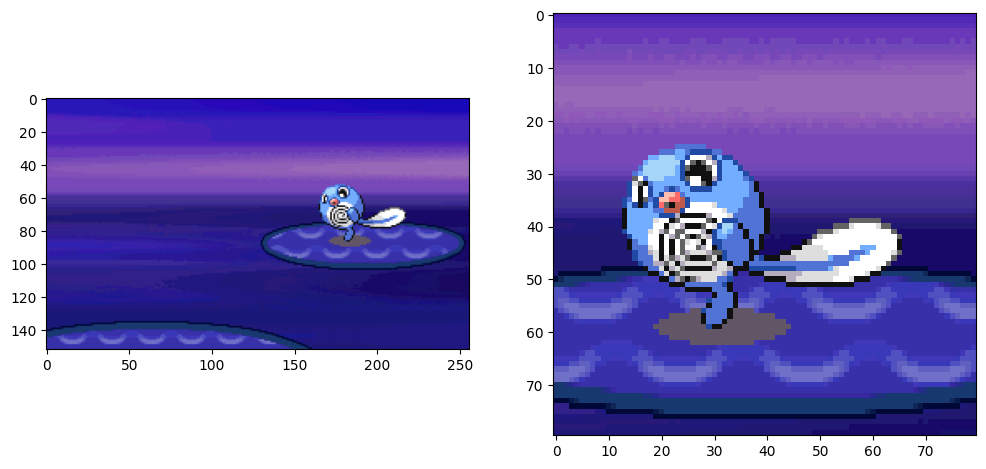

In [ ]:
import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image

train_imgs = list(Path(f"../dataset/images/train").glob("*.png"))
rand_file = random.choice(train_imgs)
print(rand_file.stem)

train_img = Image.open(rand_file)
print(train_img.width, train_img.height)
with open(f"../dataset/labels/train/{rand_file.stem}.txt", "r") as f:
    content = f.read()
class_num, center_x, center_y, width, height = content.split(" ")

center_x, center_y, width, height = float(center_x) * train_img.width, float(center_y) * train_img.height, float(width) * train_img.width, float(height) * train_img.height
print(center_x, center_y, width, height)
x1, y1, x2, y2 = center_x - (width / 2), center_y - (height / 2), center_x + (width / 2), center_y + (height / 2)
cropped_img = train_img.crop((x1, y1, x2, y2))

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(train_img)
plt.subplot(1, 2, 2)
plt.imshow(cropped_img)